# Environment

In [144]:
import numpy as np
import json
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Data Loading

In [104]:
data_path = "../scrape/data/data.npy"
dates_path = "../scrape/data/dates.json"
tweets_path = "../scrape/data/tweets.json"

data = np.load(data_path)

with open(dates_path) as json_file:  
    dates = json.load(json_file)
    
with open(tweets_path) as json_file:  
    tweets = json.load(json_file)

# Estimation

Steps:

Z is our latent variable, the stock price change from t-2 to t-1. A is our causal variable, the number of times musk tweeted from t-1 to t. Y is our outcome, the stock price change from t-1 to t.

1. Do linear regression to find E[Y|X=x, S=s].
2. Use our function from #1 to calculate E[Y|do(X=x)] = $\sum_{s}Pr(S=s)E[Y|X=x, S=s] \approx \frac{1}{n}\sum_{i=1}^{n}E[Y|X=x,S=s_{i}]$.

# Regression

## Linear Regression

In [105]:
def linear_regression_model(data):
    model = LinearRegression().fit(data[:,0:data.shape[1]-1], data[:,data.shape[1]-1])
    return model

In [134]:
model = LinearRegression().fit(data[:,0:4], data[:,4])
r_sq = model.score(data[:,0:4], data[:,4])
#print('coefficient of determination:', r_sq)
y_pred = model.predict(data[:,0:4])
#y_pred
np.mean(np.abs(data[:,4] - y_pred))
#np.mean(np.abs(data[:,4]))
#np.std(np.abs(data[:,4]))

3.8104766499373275

# Causal Estimation

In [138]:
def estimation_backdoor(model, data, do_x):
    num = 0
    total = 0
    
    for i in range(len(data)):
        if data[i, data.shape[1]-2] == do_x:
            num = num + 1
            total_add = model.predict(data[i, 0:data.shape[1]-1].reshape(1,-1))[0]
            total = total + total_add
    
    total = total/num
    
    return total

In [107]:
def average_treatment_estimation_backdoor(model, data, do_x_1, do_x_2):
    num_1 = 0
    total_1 = 0
    
    num_2 = 0
    total_2 = 0
    
    for i in range(len(data)):
        if data[i, data.shape[1]-2] == do_x_1:
            num_1 = num_1 + 1
            total_add = model.predict(data[i, 0:data.shape[1]-1].reshape(1,-1))[0]
            total_1 = total_1 + total_add
            
        if data[i, data.shape[1]-2] == do_x_2:
            num_2 = num_2 + 1
            total_add = model.predict(data[i, 0:data.shape[1]-1].reshape(1,-1))[0]
            total_2 = total_2 + total_add
    
    total_1 = total_1/num_1
    total_2 = total_2/num_2
    
    return total_2 - total_1

In [155]:
do_x_1 = 0
do_x_2 = 6
model = linear_regression_model(data)
ATE_backdoor = average_treatment_estimation_backdoor(model, data, do_x_1, do_x_2)

In [156]:
ATE_backdoor

-0.06637030210114267

# Analysis

In [141]:
np.mean(data[:,data.shape[1]-2])

2.9214189492590927

In [140]:
data[:, data.shape[1]-2]

array([ 0.,  0.,  0., ...,  7., 24.,  2.])

In [142]:
do_estimates = []
model = linear_regression_model(data)

for i in range(10):
    do_estimates.append(estimation_backdoor(model, data, i))

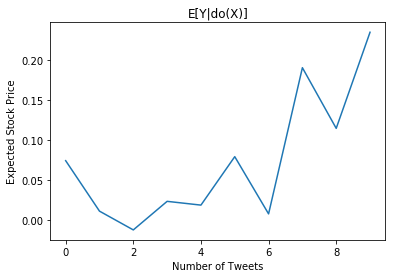

In [157]:
plt.plot(range(10), do_estimates)
plt.ylabel('Expected Stock Price')
plt.xlabel('Number of Tweets')
plt.title(r'E[Y|do(X)]')
plt.show()